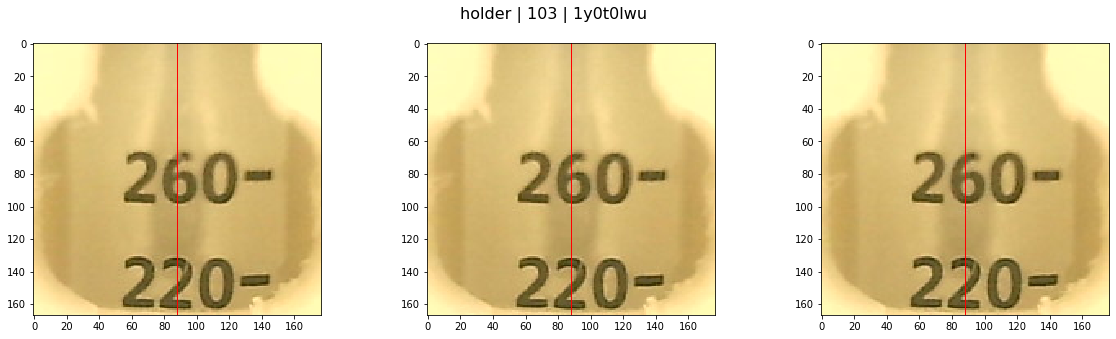

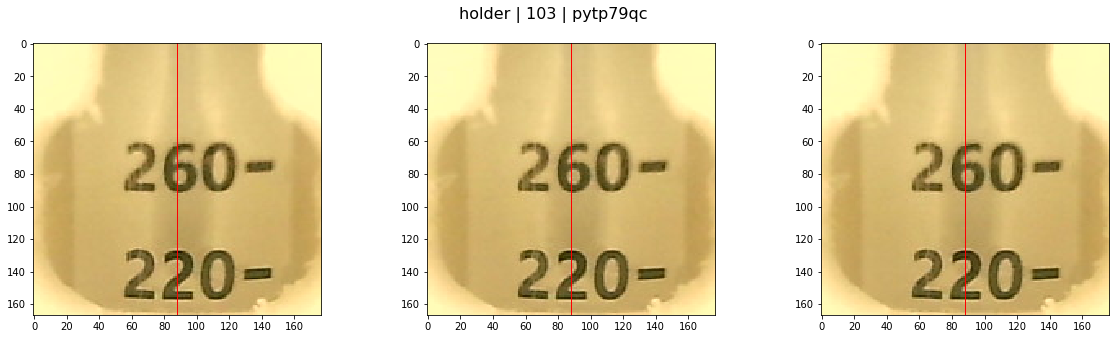

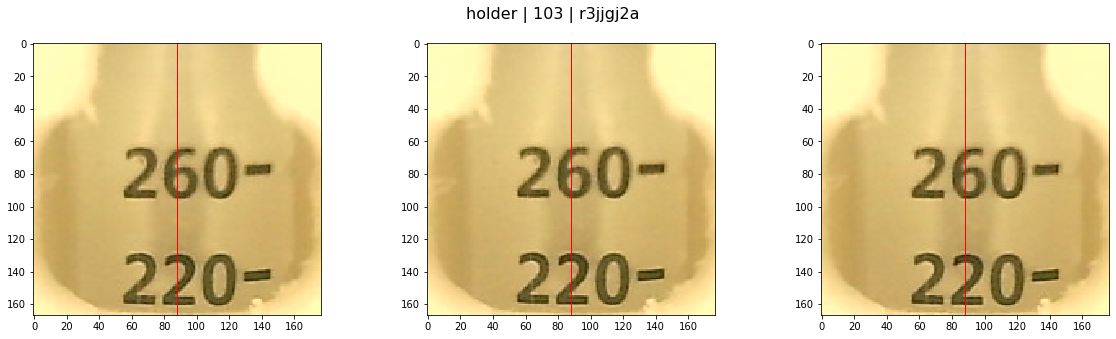

In [10]:
import glob
import matplotlib.pyplot as plt
import cv2
from importlib import reload
import annotaion
annotaion = reload(annotaion)

# print(annotaion.aligning)

nodes = [103] #annotaion.aligning.keys()
componenets = ['holder'] #, 'dosing']
for node in nodes:
    for component in componenets:
        for dataset_name in annotaion.aligning[node][component]:
            dataset_dict = annotaion.aligning[node][component][dataset_name]
            path = '../../dataset/%s_%d_%s_192.168.44.%d' % (component, node, dataset_name, node)
            files = glob.glob(path + '/*.png')

            zero_filenames = [filename for filename in files if int(filename.split('/')[-1].split('_')[0]) == dataset_dict['zero']]
            
            roi = dataset_dict = annotaion.aligning[node][component+'_roi']
            x0 = roi['x0']
            x1 = roi['x0'] + roi['dx']
            y0 = roi['y0']
            y1 = roi['y0'] + roi['dy']

            fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (20,5))
            fig.suptitle(' | '.join([component, str(node), dataset_name]), size=16)
            for index, filename in enumerate(zero_filenames):
                image = cv2.imread(filename)[y0:y1,x0:x1,::-1]
                if component == 'holder':
                    midpoint = int(image.shape[1] / 2)
                    image[:,midpoint:midpoint+1,0] = 255
                    image[:,midpoint:midpoint+1,1] = 0
                    image[:,midpoint:midpoint+1,2] = 0
                elif component == 'dosing':
                    midpoint = int(image.shape[0] / 2)
                    image[midpoint:midpoint+1,:,0] = 255
                    image[midpoint:midpoint+1,:,1] = 0
                    image[midpoint:midpoint+1,:,2] = 0

                axs[index].imshow(image)            